In [1]:
import json
import pandas as pd

import _pickle as cPickle
import boto3
import io

session = boto3.session.Session()
s3client = session.client('s3', config= boto3.session.Config(signature_version='s3v4'),aws_access_key_id='',
         aws_secret_access_key='')

response = s3client.get_object(Bucket='morty0112', Key='final_df_20180111.pkl')
df_0 = pd.read_pickle(io.BytesIO(response['Body'].read()))

In [2]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import statsmodels as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [20]:
import sys
stdout = sys.stdout

reload(sys)
sys.setdefaultencoding('utf-8')

sys.stdout = stdout

In [21]:
import spacy
spc_nlp = spacy.load('en')

**Add sytactic features from pickle file (syntactic feature generation takes a long time, so pickling is here to save some time)**

In [10]:
df_0 = pd.read_pickle('final_df_20180111.pkl')

In [4]:
'|||'.join(df_0.columns)

'doc_id|||path|||author_code|||essay_content|||label|||DT_max_dp_cnts|||DT_archs|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||POS_adjv_body|||DT_pos|||DT_pos_join|||DT_archs_join|||unique_lemma|||avg_stc_length|||total_stc|||POS_adjv_repeat|||POS_adjv_repeat_sum|||doc2vec_lm_token'

**Generate lexical features**

In [17]:
df_0['unique_lemma'] = df_0['essay_content'].apply(lambda x: len(set([token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])))

In [18]:
df_0['avg_stc_length'] = df_0['essay_content'].apply(lambda x: np.mean([len(s) for s in spc_nlp(x.decode('utf-8')).sents]))

In [19]:
df_0['total_stc'] = df_0['essay_content'].apply(lambda x: len([s for s in spc_nlp(x.decode('utf-8')).sents]))

In [20]:
'|||'.join(df_0.columns)

'doc_id|||path|||author_code|||essay_content|||label|||DT_max_dp_cnts|||DT_archs|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||POS_adjv_body|||DT_pos|||DT_pos_join|||DT_archs_join|||unique_lemma|||avg_stc_length|||total_stc'

In [310]:
# Save the final dataframe to a pickle file as a backup
#df_0.to_pickle('final_df_20180111.pkl')

## Modeling Experiments

In [5]:
df_0.head(2)

,doc_id,path,author_code,essay_content,label,DT_max_dp_cnts,DT_archs,DT_ROOT_idx,DT_pass_cnt,DT_mark_cnt,POS_adjv_body,DT_pos,DT_pos_join,DT_archs_join,unique_lemma,avg_stc_length,total_stc
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,"[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]",[nsubj ROOT mark nsubj ccomp acomp mark compou...,"[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[apart, nowadays, large, well, many, when, the...",[NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PAR...,NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART...,nsubj ROOT mark nsubj ccomp acomp mark compoun...,94,19.538462,13
1,2,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a ...",CHN,"[7, 4, 4, 3, 5, 5, 5, 5, 4, 6, 6, 7, 8, 9]",[aux det amod npadvmod punct compound nsubj ac...,"[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]","[last, very, big, many, firstly, most, importa...",[VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET AD...,VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET ADJ...,aux det amod npadvmod punct compound nsubj acl...,100,16.714286,14


### More detailed EDA on these three features:

#### Essay Vocabulary

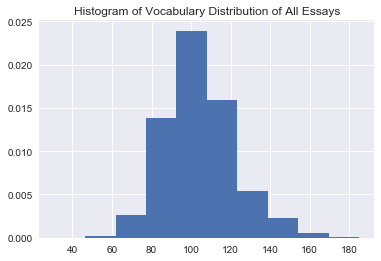

In [41]:
plt.hist(df_0['unique_lemma'], bins = 10, normed=1)
plt.title('Histogram of Vocabulary Distribution of All Essays')
plt.show()

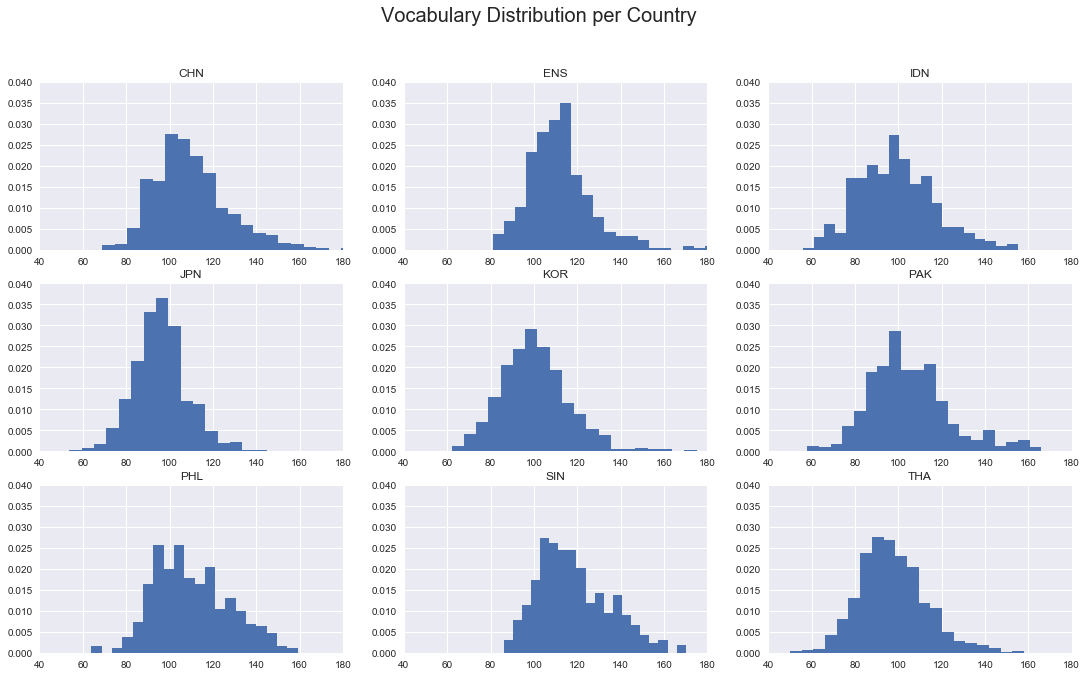

In [355]:
#cnry = ['CHN', 'ENS']
countries = list(df_0.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[df_0['label']==c]['unique_lemma']
    ax.hist(data, bins=20, normed=1)
    ax.set_xlim(40, 180)
    ax.set_ylim(0, 0.04)
    ax.set_title(c)
fig.suptitle('Vocabulary Distribution per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**Plotting vocabulary histogram by country to some degree explained the poor performance of the logistic regression model: there is not significant difference between countries on writers' vocabulary**

*Although interestingly, the distribution is slightly skewed to the left (lower vocabulary) for writers from **Indonesia**, and it is slightly skewed to the right (higher vocabulary) for writers from* **Pakistan**

#### Essay Sentence Count

In [331]:
np.percentile(df_0['total_stc'], 5)

8.0

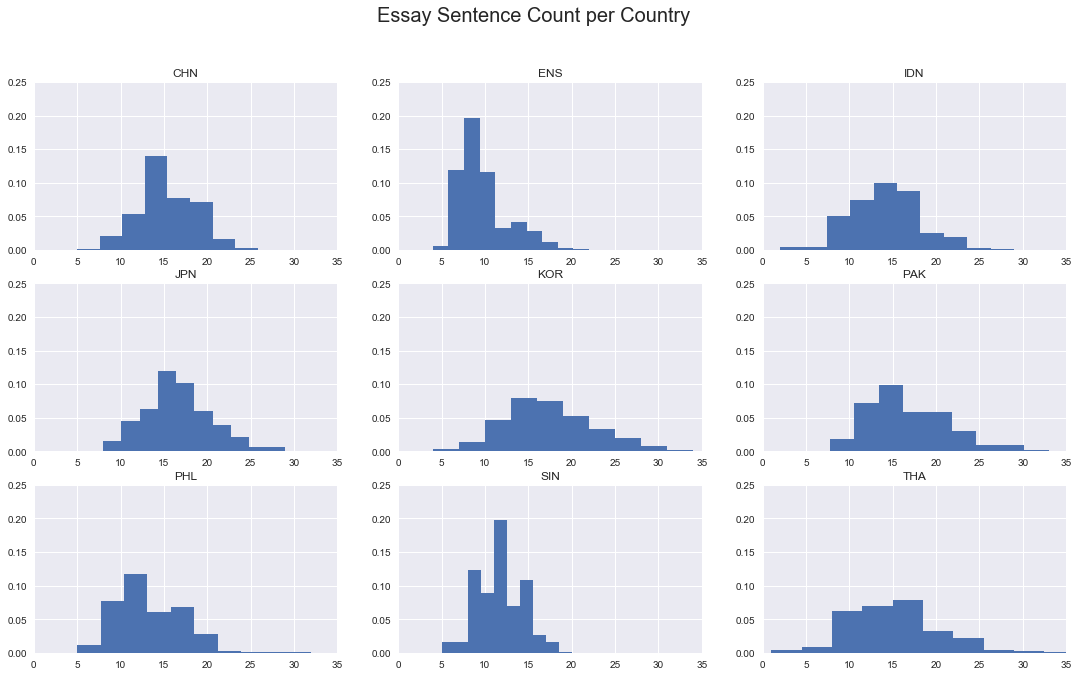

In [356]:
countries = list(df_0.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[df_0['label']==c]['total_stc']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(0, 35)
    ax.set_ylim(0, 0.25)
    ax.set_title(c)
fig.suptitle('Essay Sentence Count per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**Although the distributions are still pretty normal, essay sentence counts shows bigger difference among countries compared to essay vocabulary. E.g. native speakers' essays tend to contain less sentences, and it makes sense. Native speakers are able to use English more efficiently compare to English learners. Take learners from Japan and Korea for example, the means of sentence count are higher then native speaker group, indicating more sentences for the same given essay topic.**

*One interesting finding is that learners from **Thailand** tend to write less sentences, too! This observation led to further investigation demonstrated later in this notebook*

#### Essay Average Sentence Length

In [328]:
np.percentile(df_0['avg_stc_length'], 95)

31.006250000000023

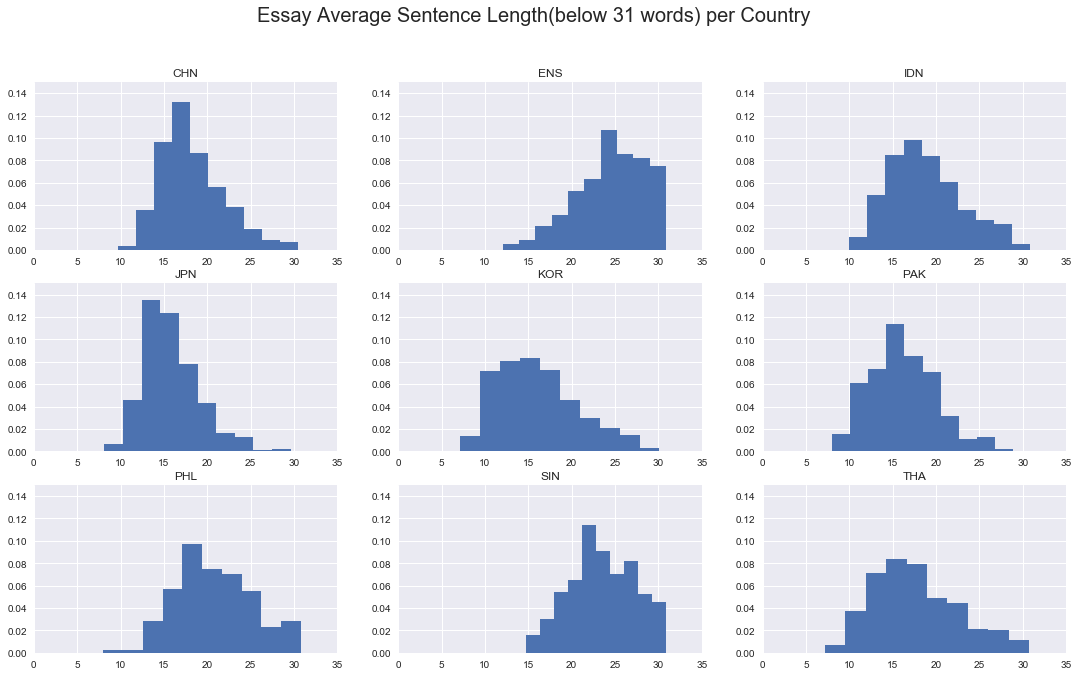

In [357]:
countries = list(df_0.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[(df_0['label']==c)&(df_0['avg_stc_length']<31)]['avg_stc_length']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(0, 35)
    ax.set_ylim(0, 0.15)
    ax.set_title(c)
fig.suptitle('Essay Average Sentence Length(below 31 words) per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

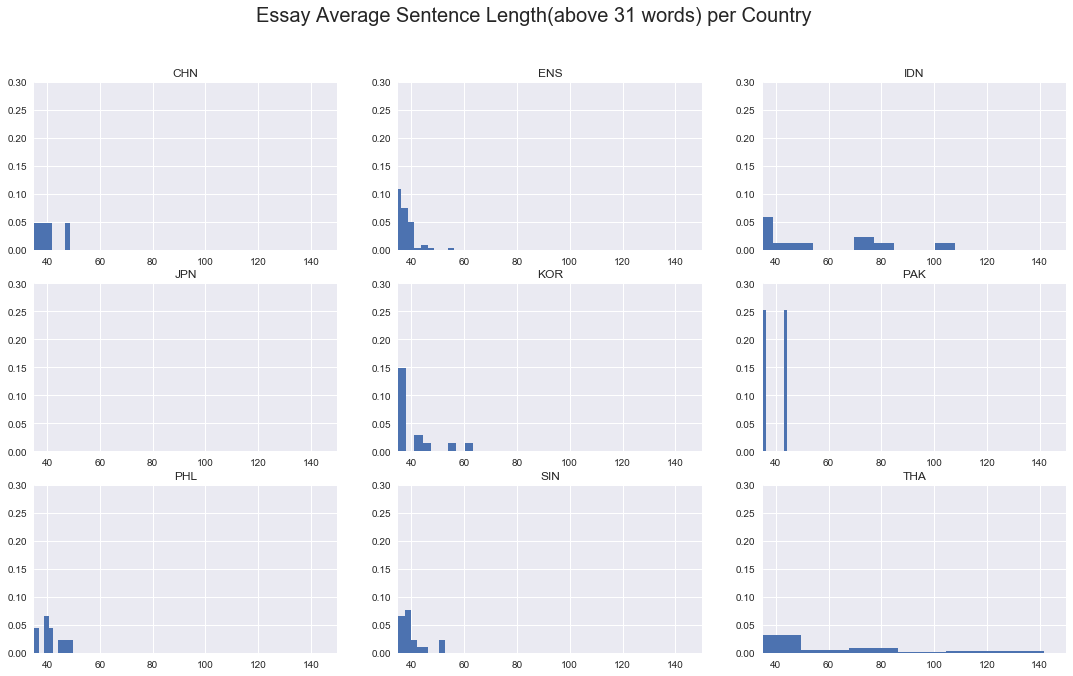

In [358]:
countries = list(df_0.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[(df_0['label']==c)&(df_0['avg_stc_length']>31)]['avg_stc_length']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(35, 150)
    ax.set_ylim(0, 0.3)
    ax.set_title(c)
fig.suptitle('Essay Average Sentence Length(above 31 words) per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**I decided to plot average sentence length(word count) using the 95 percentile word count(31) as a threshold. As shown in the first figure, most countries have normal distribution with slight skew. Native speaker group is the only one that shows a large cutoff on the right side, indicating that average sentence length for this group tend to be larger.**

**The second part of the plot shows something very interesting about learners in Thailand. It shows a wide spread over high sentence length, which indicates that Thai learners tend to not  use a full stop often. This is to some degree influenced by their native language. The Thai script doesn't use a full stop at all**

### Sentence length vs sentence count

**For standardized English tests, there is a word count requirement for the essay. Therefore, it would make sense if the sentence length and sentence count are inversely correlated**

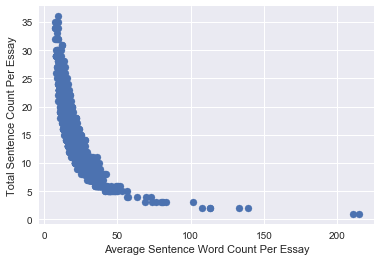

In [59]:
fig,ax = plt.subplots()
ax.scatter(df_0['avg_stc_length'], df_0['total_stc'])
ax.set_xlabel('Average Sentence Word Count Per Essay')
ax.set_ylabel('Total Sentence Count Per Essay')
plt.show()

**Now examine the two variables in each country group**

In [327]:
# Examine the actual long essay writing of Thai learners
pd.set_option('display.max_colwidth', -1)
df_0[(df_0['avg_stc_length']>40)&(df_0['label']=='THA')]['path']

4410    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_035_A2_0.txt
4436    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_116_A2_0.txt
4441    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_127_A2_0.txt
4449    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_147_A2_0.txt
4463    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_178_A2_0.txt
4465    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_180_A2_0.txt
4536    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_054_A2_0.txt
4549    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_093_A2_0.txt
4555    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_116_A2_0.txt
4568    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_147_A2_0.txt
4582    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_178_A2_0.txt
4584    data/ICNALE/Unmerged_classified/ICN

In [343]:
# Using 95 percentile
df_ave_stc_31plus = df_0[df_0['avg_stc_length']>31]
df_ave_stc_31plus.groupby(['label']).size()

label
CHN    12
ENS    95
IDN    11
KOR    21
PAK    3 
PHL    24
SIN    42
THA    42
dtype: int64

In [344]:
# Using 5 percentile
df_sent_less8 = df_0[(df_0['label']!='JPN')&(df_0['total_stc']<8)]
df_sent_less8.groupby(['label']).size()

label
CHN    4 
ENS    90
IDN    9 
KOR    15
PAK    1 
PHL    13
SIN    20
THA    37
dtype: int64

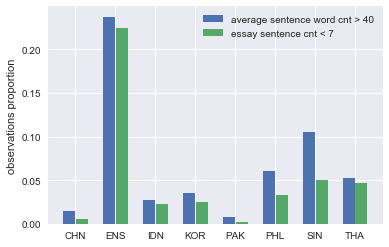

In [342]:
countries = list(df_ave_stc_40plus.groupby(['label']).size().index)
word_cnt = df_ave_stc_40plus.groupby(['label']).size().values
sent_cnt = df_sent_less7.groupby(['label']).size().values
essay_cnt_country = df_0[df_0['label']!='JPN'].groupby(['label']).size().values
#essay_cnt_country = df_0.groupby(['label']).size().values

fig, ax = plt.subplots()
ax.bar(np.arange(len(countries)), word_cnt*1./essay_cnt_country, 0.3, label='average sentence word cnt > 40')
ax.bar(np.arange(len(countries))+0.32, sent_cnt*1./essay_cnt_country, 0.3, label='essay sentence cnt < 7')
ax.set_ylabel('observations proportion')
plt.xticks(np.arange(len(countries))+0.16, countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
ax.legend()
fig.show()

**Interestingly, while most language groups have similar portion of essays with both natures (average sentence word count>40 and essay sentence count<7), learners from Singapore tend to write essays with long sentences while not decrease the sentence word count.**

### Using only simple numeric essay statistics

In [129]:
X = df_0[['unique_lemma','avg_stc_length','total_stc']]
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [130]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.296564827055


In [131]:
# Skipping gridsearch for now since this is just basic model exploration
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.236741676254


In [132]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.295226796065


**Using three simple numeric features that represent simple characters of an essay, the classification result is better than randomly guessing, but it still does not produce great result**

**-**

### Using syntactic features 

In [142]:
'|||'.join(df_0.columns)

'doc_id|||path|||author_code|||essay_content|||label|||DT_max_dp_cnts|||DT_archs|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||POS_adjv_body|||DT_pos|||DT_pos_join|||DT_archs_join|||unique_lemma|||avg_stc_length|||total_stc'

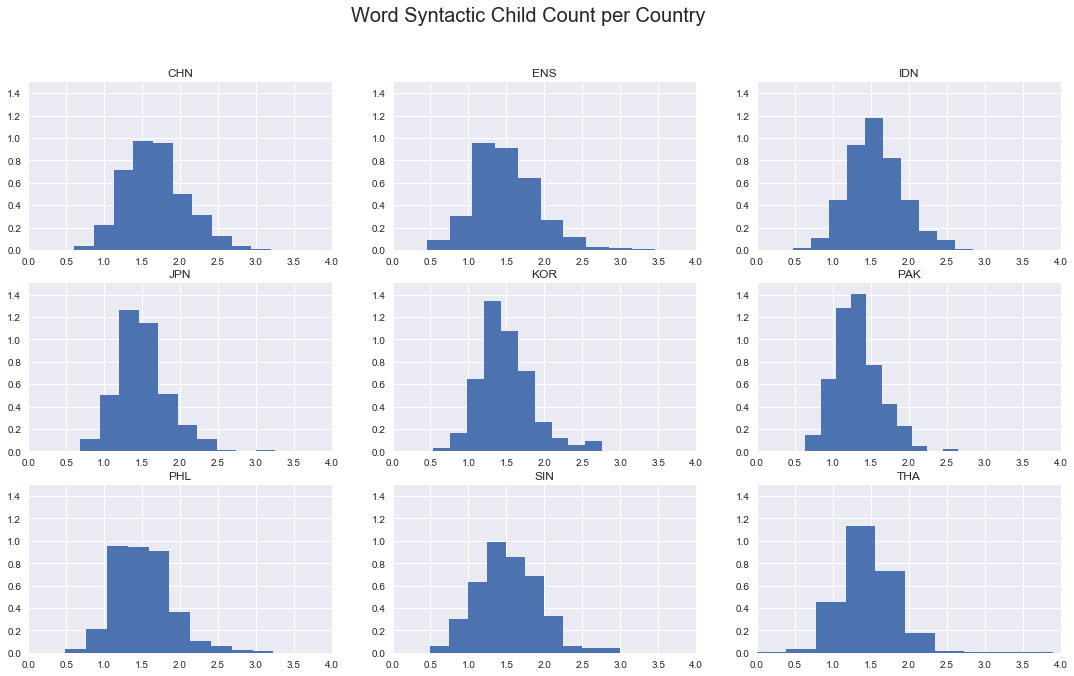

In [8]:
pwk.plot_pattern_country(df_0, 'DT_max_dp_cnts', np.std, 0, 4, 0, 1.5, 'Word Syntactic Child Count per Country')

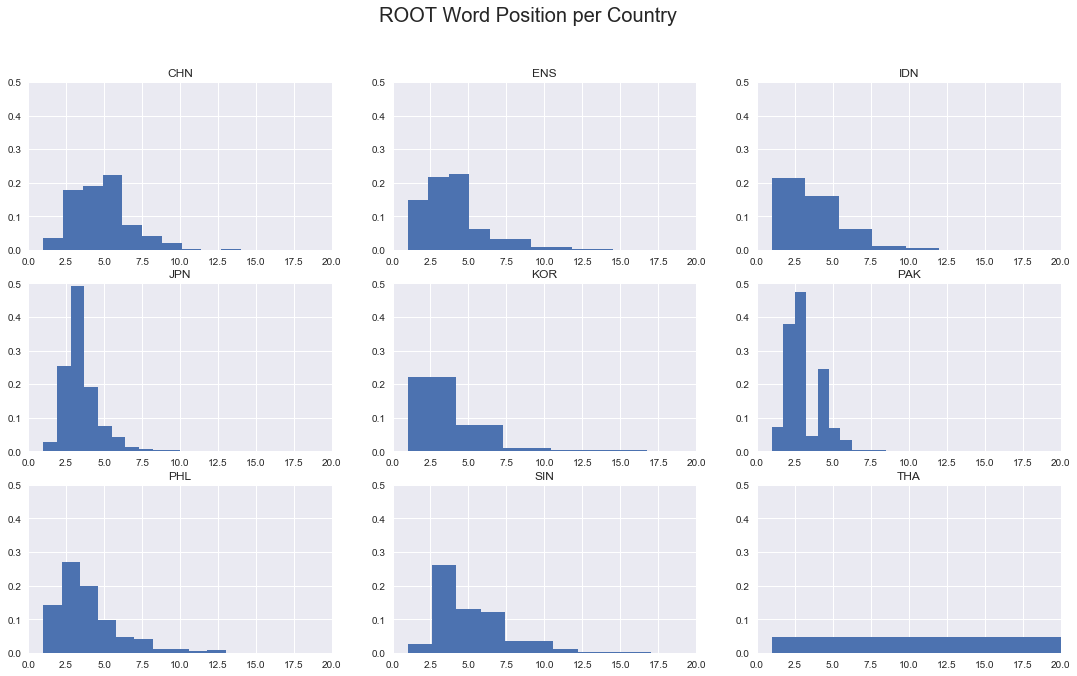

In [360]:
pwk.plot_pattern_country(df_0, 'DT_ROOT_idx', np.median, 0, 20, 0, 0.5, 'ROOT Word Position per Country')

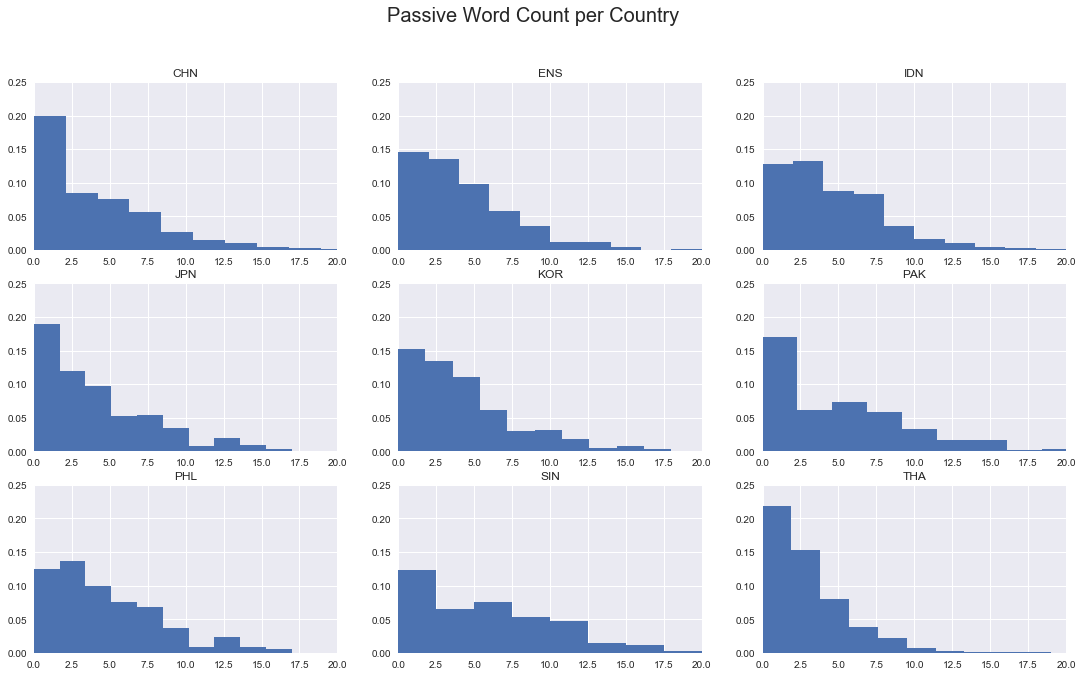

In [362]:
pwk.plot_pattern_country(df_0, 'DT_pass_cnt', np.sum, 0, 20, 0, 0.25, 'Passive Word Count per Country')

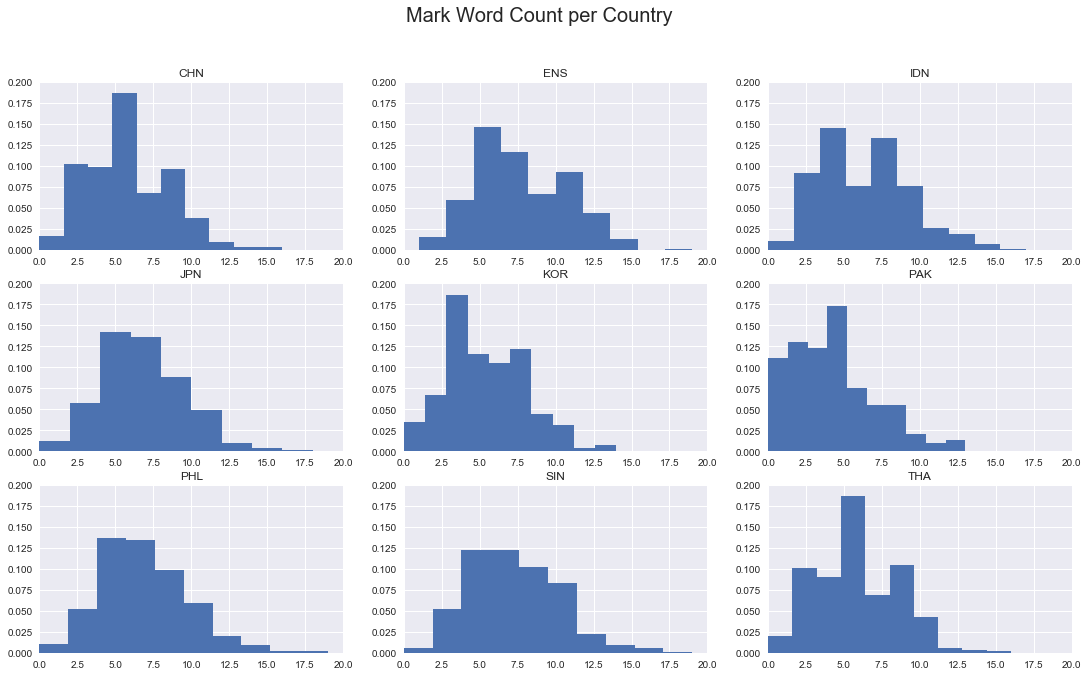

In [363]:
pwk.plot_pattern_country(df_0, 'DT_mark_cnt', np.sum, 0, 20, 0, 0.2, 'Mark Word Count per Country')

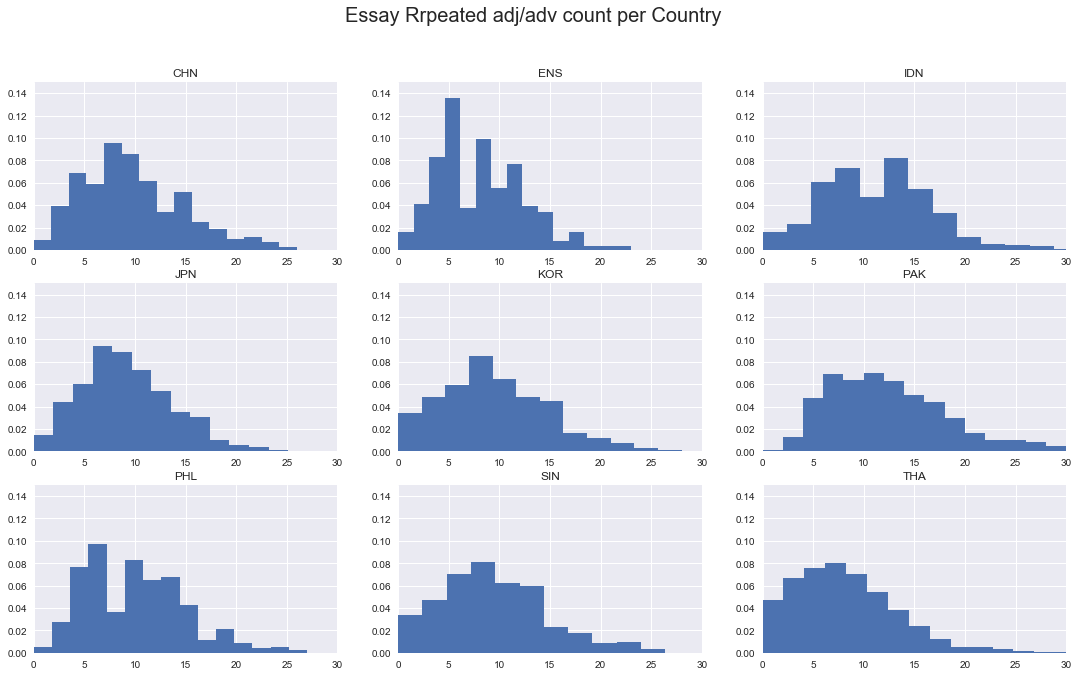

In [364]:
countries = list(df_0.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_0[(df_0['label']==c)]['POS_adjv_repeat_sum']
    ax.hist(data, bins=15, normed=1)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.15)
    ax.set_title(c)
fig.suptitle('Essay Rrpeated adj/adv count per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

In [222]:
df_1 = df_0
df_1['DT_max_dp_cnts_std'] = df_1['DT_max_dp_cnts'].apply(lambda x: np.std(x))
df_1['DT_ROOT_idx_mean'] = df_1['DT_ROOT_idx'].apply(lambda x: np.mean(x))
df_1['DT_pass_cnt_sum'] = df_1['DT_pass_cnt'].apply(lambda x: np.sum(x))
df_1['DT_mark_cnt_sum'] = df_1['DT_mark_cnt'].apply(lambda x: np.sum(x))

In [223]:
X = df_1[['unique_lemma','avg_stc_length','total_stc','DT_max_dp_cnts_std','DT_ROOT_idx_mean',\
         'DT_pass_cnt_sum','DT_mark_cnt_sum','POS_adjv_repeat_sum']]
y = df_1['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [224]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.349845598945


In [227]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.363981106714


In [226]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.342652682215


**Accuracy increased slightly, but still not great**

**-**

## POS tagging and syntactic tree parsing features

In [228]:
df_0.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join', u'unique_lemma', u'avg_stc_length', u'total_stc',
       u'POS_adjv_repeat', u'POS_adjv_repeat_sum', u'DT_max_dp_cnts_std',
       u'DT_ROOT_idx_mean', u'DT_pass_cnt_sum', u'DT_mark_cnt_sum'],
      dtype='object')

### Generate tf/tf-idf matrix on pos tag body for essays

In [230]:
#df_0.DT_pos_join

In [232]:
X = df_0['DT_pos_join']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [243]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.495077441085


In [242]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.359698012852


In [244]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.533472477499


In [245]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.587889708964


In [266]:
X = df_0['DT_archs_join']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [247]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.58029550397


In [248]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.388476170165


In [301]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

In [250]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.597941802412


### pos ngram with sentence boundary

In [274]:
n = 3
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [275]:
X = df_0['DT_insent_pos_ngram']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [276]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.659489860962


In [ ]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

In [ ]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

In [277]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.457155618071


**arch ngram with sentence boundary**

In [260]:
n = 3
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [71]:
X = df_0['DT_insent_arch_ngram']
y = df_0['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [78]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())#solver='newton-cg', multi_class='multinomial'))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.692601212334


In [265]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.410071334322


In [ ]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

In [271]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.457983118683


**-**

## Doc2Vec matrix featurs

#### Vectorize: essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

In [41]:
n = 6
df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [34]:
n = 5
df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [36]:
cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
(df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
df_input = df_0[cond]

In [37]:
cv_data, test_data = train_test_split(df_input, test_size=0.1)

**Cross validation using different classifiers**

In [75]:
import itertools

ngram_range = [i for i in range(2,11)]
window_range = [i for i in range(1,6)]

combs = list(itertools.product(ngram_range, window_range))

In [42]:
col = 'DT_insent_arch_ngram'
# essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

In [3]:
col = 'DT_insent_arch_ngram'
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', str(1))
    n = ng
    df_0['DT_insent_arch_ngram'] = df_0['DT_archs'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
    (df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
    df_input = df_0[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 100, clf, literal=False))

ngram_n:  2
window size:  1
[0.31555555555555553, 0.29444444444444445, 0.32666666666666666, 0.34666666666666668, 0.32222222222222224]
ngram_n:  3
window size:  1
[0.29888888888888887, 0.27111111111111114, 0.25222222222222224, 0.29555555555555557, 0.26666666666666666]
ngram_n:  4
window size:  1
[0.37444444444444447, 0.34666666666666668, 0.36333333333333334, 0.37111111111111111, 0.38444444444444442]
ngram_n:  5
window size:  1
[0.40666666666666668, 0.40444444444444444, 0.44, 0.42444444444444446, 0.45333333333333331]
ngram_n:  6
window size:  1
[0.39555555555555555, 0.3888888888888889, 0.38444444444444442, 0.38555555555555554, 0.39444444444444443]
ngram_n:  7
window size:  1
[0.29777777777777775, 0.31111111111111112, 0.28555555555555556, 0.33000000000000002, 0.32222222222222224]
ngram_n:  8
window size:  1
[0.2722222222222222, 0.25888888888888889, 0.26555555555555554, 0.23222222222222222, 0.2388888888888889]
ngram_n:  9
window size:  1
[0.22777777777777777, 0.25888888888888889, 0.2522222

In [4]:
col = 'DT_insent_pos_ngram'
#for c in combs:
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', 1)
    n = ng
    df_0['DT_insent_pos_ngram'] = df_0['DT_pos'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
    (df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
    df_input = df_0[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 80, clf, literal=False))

ngram_n:  2
window size:  1
[0.42666666666666669, 0.44222222222222224, 0.42666666666666669, 0.41888888888888887, 0.42777777777777776]
ngram_n:  3
window size:  1
[0.26111111111111113, 0.23999999999999999, 0.2311111111111111, 0.21777777777777776, 0.24333333333333335]
ngram_n:  4
window size:  1
[0.2722222222222222, 0.26111111111111113, 0.28888888888888886, 0.27777777777777779, 0.28999999999999998]
ngram_n:  5
window size:  1
[0.37888888888888889, 0.34888888888888892, 0.35333333333333333, 0.35777777777777775, 0.33333333333333331]
ngram_n:  6
window size:  1
[0.39111111111111113, 0.3888888888888889, 0.37444444444444447, 0.4211111111111111, 0.40000000000000002]
ngram_n:  7
window size:  1
[0.37777777777777777, 0.38111111111111112, 0.3477777777777778, 0.37666666666666665, 0.3888888888888889]
ngram_n:  8
window size:  1
[0.27888888888888891, 0.30222222222222223, 0.31, 0.28888888888888886, 0.2911111111111111]
ngram_n:  9
window size:  1
[0.26111111111111113, 0.23555555555555555, 0.25666666666

In [5]:
col = 'essay_content'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
    (df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
    df_input = df_0[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

window size:  1
[0.81777777777777783, 0.81333333333333335, 0.83444444444444443, 0.81777777777777783, 0.8322222222222222]
window size:  2
[0.82777777777777772, 0.86444444444444446, 0.82999999999999996, 0.8288888888888889, 0.85111111111111115]
window size:  3
[0.85444444444444445, 0.82333333333333336, 0.83666666666666667, 0.83333333333333337, 0.81999999999999995]
window size:  4
[0.82444444444444442, 0.81000000000000005, 0.82111111111111112, 0.81888888888888889, 0.83666666666666667]
window size:  5
[0.82222222222222219, 0.7844444444444445, 0.83111111111111113, 0.82444444444444442, 0.80222222222222217]
window size:  6
[0.81444444444444442, 0.81555555555555559, 0.82222222222222219, 0.79222222222222227, 0.82777777777777772]
window size:  7
[0.77666666666666662, 0.81555555555555559, 0.81777777777777783, 0.80333333333333334, 0.82222222222222219]
window size:  8
[0.79666666666666663, 0.78666666666666663, 0.80333333333333334, 0.7877777777777778, 0.80444444444444441]
window size:  9
[0.785555555

In [7]:
col = 'DT_archs_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
    (df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
    df_input = df_0[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

window size:  1
[0.35999999999999999, 0.36444444444444446, 0.34111111111111109, 0.33111111111111113, 0.33333333333333331]
window size:  2
[0.31666666666666665, 0.33444444444444443, 0.36333333333333334, 0.34444444444444444, 0.34555555555555556]
window size:  3
[0.35444444444444445, 0.36777777777777776, 0.34000000000000002, 0.33777777777777779, 0.33111111111111113]
window size:  4
[0.33666666666666667, 0.32000000000000001, 0.30777777777777776, 0.34888888888888892, 0.3611111111111111]
window size:  5
[0.33333333333333331, 0.32666666666666666, 0.34888888888888892, 0.30111111111111111, 0.35777777777777775]
window size:  6
[0.3511111111111111, 0.34000000000000002, 0.31555555555555553, 0.33333333333333331, 0.33666666666666667]
window size:  7
[0.32333333333333331, 0.34444444444444444, 0.31111111111111112, 0.35444444444444445, 0.32333333333333331]
window size:  8
[0.31111111111111112, 0.30777777777777776, 0.36222222222222222, 0.37111111111111111, 0.34000000000000002]
window size:  9
[0.3255555

In [8]:
col = 'DT_pos_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_0['label']!='ENS')|(df_0['label']!='CHN')|\
    (df_0['label']!='JPN')|(df_0['label']!='KOR')|(df_0['label']!='THA')
    df_input = df_0[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

window size:  1
[0.24666666666666667, 0.22222222222222221, 0.22555555555555556, 0.25333333333333335, 0.23333333333333334]
window size:  2
[0.22222222222222221, 0.22555555555555556, 0.21777777777777776, 0.24444444444444444, 0.23999999999999999]
window size:  3
[0.22444444444444445, 0.22333333333333333, 0.23999999999999999, 0.21666666666666667, 0.23777777777777778]
window size:  4
[0.24444444444444444, 0.19777777777777777, 0.22777777777777777, 0.23666666666666666, 0.24444444444444444]
window size:  5
[0.23999999999999999, 0.2311111111111111, 0.24111111111111111, 0.22111111111111112, 0.22333333333333333]
window size:  6
[0.21333333333333335, 0.23444444444444446, 0.22, 0.24111111111111111, 0.21777777777777776]
window size:  7
[0.23222222222222222, 0.23444444444444446, 0.25111111111111112, 0.22666666666666666, 0.22777777777777777]
window size:  8
[0.21888888888888888, 0.23000000000000001, 0.24111111111111111, 0.23333333333333334, 0.24888888888888888]
window size:  9
[0.2311111111111111, 0.2

**Based on the expereiments on different features, using essay_content for final train and test**

In [9]:
cv_data, test_data = train_test_split(df_input, test_size=0.1)
col = 'essay_content'

train_docs = pwk.tag_docs(cv_data, col, literal=True)
test_docs = pwk.tag_docs(test_data, col, literal=True)
model = pwk.train_doc2vec_model_new(train_docs, 1, 30)
    
y_train, X_train = pwk.vec_for_learning(model, train_docs)
y_test, X_test = pwk.vec_for_learning(model, test_docs)
    
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [11]:
print (accuracy_score(y_test, y_pred))

0.814
